<a href="https://colab.research.google.com/github/Theekshana-se/Air-QualityPredict-DeepLearningProject/blob/RNN/IT22216878_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Air Quality Forecasting (RNN) — v2 (Leakage‑safe, lagged target included)

This revision fixes flat validation loss by:
- fitting scalers **only on the training segment**,
- including **past target values** as an input feature (lagged target),
- building windows **per split** to prevent leakage.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os, math, warnings, pickle, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CSV_PATH   = "/content/drive/MyDrive/data.csv"
TARGET     = "no2"
LOOKBACK   = 24
HORIZON    = 1
TEST_FRAC  = 0.15
VAL_FRAC   = 0.15
MIN_TRAIN  = 64
MIN_VAL    = 16
MIN_TEST   = 16

assert os.path.exists(CSV_PATH), f"Dataset not found: {CSV_PATH}"
print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [4]:

# Load dataset robustly
encodings = ["utf-8","latin-1","cp1252"]
df = None
for enc in encodings:
    try:
        df = pd.read_csv(CSV_PATH, encoding=enc)
        break
    except Exception as e:
        last_err = e
if df is None:
    raise ValueError(f"Could not read CSV. Last error: {last_err}")

df.columns = [c.strip() for c in df.columns]

# Detect date column (optional)
date_candidates = [c for c in df.columns if c.lower() in ["date","datetime","timestamp"]]
dt_col = date_candidates[0] if date_candidates else None
if dt_col:
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=[dt_col])
    df = df.sort_values(dt_col).reset_index(drop=True)

# Target detection
target_candidates = [TARGET, "PM25","pm2_5","pm25","AQI","aqi"]
lower_map = {c.lower(): c for c in df.columns}
found = None
for name in target_candidates:
    if name in df.columns:
        found = name; break
    if name.lower() in lower_map:
        found = lower_map[name.lower()]; break
if found is None:
    raise ValueError(f"Target column not found. Columns: {list(df.columns)[:30]}")
TARGET = found
print("Using target:", TARGET)

# Keep numeric columns, ensure target numeric
num_df = df.select_dtypes(include=[np.number]).copy()
if TARGET not in num_df.columns:
    num_df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")

# Impute numeric with medians
imp = SimpleImputer(strategy="median")
num_np = imp.fit_transform(num_df)
num_df = pd.DataFrame(num_np, columns=num_df.columns, index=num_df.index)

# IMPORTANT: keep TARGET inside features so the model sees lagged TARGET
values = num_df.values  # (N, F_all) includes TARGET
cols = list(num_df.columns)
F_all = values.shape[1]

# Identify target index (for readability only; not used for slicing below)
target_idx = cols.index(TARGET)

N = len(values)
print("Rows:", N, "| Features (including target):", F_all)


Using target: no2
Rows: 435735 | Features (including target): 5


In [5]:

# Split indices (time-ordered) before scaling
def compute_splits(N, test_frac, val_frac):
    test_n = max(MIN_TEST, int(math.ceil(test_frac * N)))
    trainval_n = N - test_n
    if trainval_n < (MIN_TRAIN + MIN_VAL):
        test_n = max(MIN_TEST, N - (MIN_TRAIN + MIN_VAL))
        trainval_n = N - test_n
    val_n = max(MIN_VAL, int(math.ceil(val_frac * trainval_n)))
    train_n = trainval_n - val_n
    if train_n < MIN_TRAIN:
        val_n = max(MIN_VAL, trainval_n - MIN_TRAIN)
        train_n = trainval_n - val_n
    return train_n, val_n, test_n

train_n, val_n, test_n = compute_splits(N, TEST_FRAC, VAL_FRAC)
print(f"Split rows (pre-window): train={train_n}, val={val_n}, test={test_n}")

train_end = train_n
val_end   = train_n + val_n

train_raw = values[:train_end]
val_raw   = values[train_end:val_end]
test_raw  = values[val_end:]


Split rows (pre-window): train=314817, val=55557, test=65361


In [6]:

# Fit scalers ONLY on training segment
x_scaler = RobustScaler()
y_scaler = RobustScaler()

# X = all features (including target), y = target-only column for each segment
Xtr_raw, ytr_raw = train_raw, train_raw[:, [target_idx]]
Xva_raw, yva_raw = val_raw,   val_raw[:,   [target_idx]]
Xte_raw, yte_raw = test_raw,  test_raw[:,  [target_idx]]

x_scaler.fit(Xtr_raw)
y_scaler.fit(ytr_raw)

Xtr = x_scaler.transform(Xtr_raw)
Xva = x_scaler.transform(Xva_raw)
Xte = x_scaler.transform(Xte_raw)

ytr = y_scaler.transform(ytr_raw)
yva = y_scaler.transform(yva_raw)
yte = y_scaler.transform(yte_raw)

print("Scaled shapes:", Xtr.shape, Xva.shape, Xte.shape)


Scaled shapes: (314817, 5) (55557, 5) (65361, 5)


In [7]:

# Window builders per split (no leakage across splits)
def build_windows(Xs, ys, lookback, horizon):
    N = len(Xs)
    M = N - lookback - horizon + 1
    if M <= 0:
        return np.empty((0, lookback, Xs.shape[1])), np.empty((0, 1))
    Xw = np.zeros((M, lookback, Xs.shape[1]), dtype=np.float32)
    yw = np.zeros((M, 1), dtype=np.float32)
    for i in range(M):
        Xw[i] = Xs[i:i+lookback]
        yw[i] = ys[i + lookback + horizon - 1]
    return Xw, yw

def ensure_min_windows(Xs, ys, lookback, horizon, minimum):
    lb = int(lookback)
    while lb >= 2:
        Xw, yw = build_windows(Xs, ys, lb, horizon)
        if len(Xw) >= minimum:
            return Xw, yw, lb
        lb -= 1
    Xw, yw = build_windows(Xs, ys, 2, horizon)
    return Xw, yw, 2

# try to meet minimums per split
Xw_tr, yw_tr, LB_tr = ensure_min_windows(Xtr, ytr, LOOKBACK, HORIZON, MIN_TRAIN)
Xw_va, yw_va, LB_va = ensure_min_windows(Xva, yva, LOOKBACK, HORIZON, MIN_VAL)
Xw_te, yw_te, LB_te = ensure_min_windows(Xte, yte, LOOKBACK, HORIZON, MIN_TEST)

LOOKBACK_USED = min(LB_tr, LB_va, LB_te)
print("LOOKBACK_USED:", LOOKBACK_USED)

# Rebuild with the common LOOKBACK_USED so shapes match
Xw_tr, yw_tr = build_windows(Xtr, ytr, LOOKBACK_USED, HORIZON)
Xw_va, yw_va = build_windows(Xva, yva, LOOKBACK_USED, HORIZON)
Xw_te, yw_te = build_windows(Xte, yte, LOOKBACK_USED, HORIZON)

print("Windows:", len(Xw_tr), len(Xw_va), len(Xw_te))
n_features = Xw_tr.shape[2]


LOOKBACK_USED: 24
Windows: 314793 55533 65337


In [8]:

# Naive baseline (persistence): y_hat(t+1) = y(t)
def naive_baseline(y_seq):
    # MSE computed directly on scaled y for comparability
    # For validation: use available windows count
    return np.var(y_seq)  # not precise; better compute per-window baseline below

def baseline_eval(y_windows, lookback):
    # Predict next value as last value of the window (scaled)
    y_last = []
    for i in range(len(y_windows)):
        y_last.append(y_windows[i, -1, target_idx])  # last row's TARGET in features
    y_last = np.array(y_last).reshape(-1,1)
    return y_last

yhat_va_base = baseline_eval(Xw_va, LOOKBACK_USED)
mse_base_va = mean_squared_error(yw_va, yhat_va_base)
print(f"Baseline validation MSE (scaled): {mse_base_va:.4f}")


Baseline validation MSE (scaled): 1.5784


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 1.0820 - val_loss: 0.8397 - learning_rate: 0.0010
Epoch 2/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - loss: 1.0577 - val_loss: 0.8431 - learning_rate: 0.0010
Epoch 3/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 1.0532 - val_loss: 0.8335 - learning_rate: 0.0010
Epoch 4/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 1.0500 - val_loss: 0.8327 - learning_rate: 0.0010
Epoch 5/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 1.0502 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 6/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 1.0482 - val_loss: 0.8465 - learning_rate: 0.0010
Epoch 7/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 1.0471 - val_loss: 0.8363 - learning_rate: 0.0010
Epoch 8/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 1.0464 - val_loss: 0.8352 - learning_rate: 0.0010
Epoch 9/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 1.0468 - val_lo

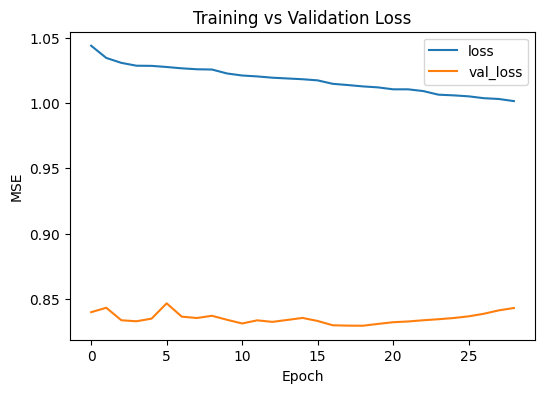

In [9]:

# Build and train RNN
tf.keras.backend.clear_session()

model = keras.Sequential([
    layers.Input(shape=(LOOKBACK_USED, n_features)),
    layers.SimpleRNN(64, activation="tanh"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

batch = max(1, min(128, len(Xw_tr)))
hist = model.fit(
    Xw_tr, yw_tr,
    validation_data=(Xw_va, yw_va),
    epochs=100,
    batch_size=batch,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(hist.history.get("loss", []), label="loss")
plt.plot(hist.history.get("val_loss", []), label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()


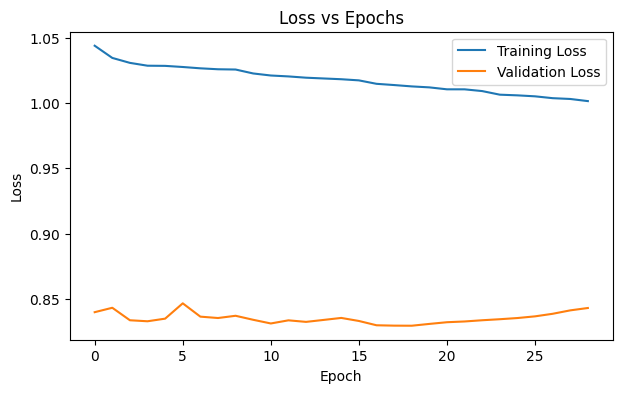

In [15]:
# Plot Loss vs Epochs
import matplotlib.pyplot as plt
import pandas as pd

h = pd.DataFrame(hist.history)

plt.figure(figsize=(7,4))
plt.plot(h["loss"], label="Training Loss")
plt.plot(h["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# If you have accuracy in your model metrics
if "accuracy" in h.columns:
    plt.figure(figsize=(7,4))
    plt.plot(h["accuracy"], label="Training Accuracy")
    plt.plot(h["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [10]:

# Evaluate vs baseline in scaled units
yhat_va = model.predict(Xw_va, verbose=0)
mse_va = mean_squared_error(yw_va, yhat_va)
print(f"Validation MSE (scaled): {mse_va:.4f}")
print(f"Baseline  MSE (scaled): {mse_base_va:.4f}")

# Test metrics in original units
yhat_te_s = model.predict(Xw_te, verbose=0)
yhat_te = y_scaler.inverse_transform(yhat_te_s)
ytrue_te = y_scaler.inverse_transform(yw_te)

rmse = float(np.sqrt(mean_squared_error(ytrue_te, yhat_te)))
mae  = float(mean_absolute_error(ytrue_te, yhat_te))
r2   = float(r2_score(ytrue_te, yhat_te))

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE : {mae:.3f}")
print(f"Test R2  : {r2:.3f}")


Validation MSE (scaled): 0.8293
Baseline  MSE (scaled): 1.5784
Test RMSE: 18.302
Test MAE : 12.492
Test R2  : -0.040


In [11]:
import numpy as np

def recursive_forecast_with_target_feedback(model, x_scaler, y_scaler,
                                            values, target_idx, lookback, steps=7):
    """
    Multi-step recursive forecast:
    - Build last window from the **scaled** full feature matrix (fit on train only).
    - Predict scaled target, write it back into the target slot of the next row.
    - Keep non-target features as the last observed values (simple assumption).
    Returns predictions in original units.
    """
    X_scaled_full = x_scaler.transform(values)
    if len(X_scaled_full) < lookback:
        raise ValueError("Not enough rows to build the last window.")

    window = X_scaled_full[-lookback:].astype(np.float32).copy()  # (lookback, F)
    preds_scaled = []
    for _ in range(int(steps)):
        yhat_s = model.predict(window[np.newaxis, ...], verbose=0)[0, 0]
        preds_scaled.append(yhat_s)
        new_row = window[-1].copy()
        new_row[target_idx] = yhat_s
        window = np.vstack([window[1:], new_row])

    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    return y_scaler.inverse_transform(preds_scaled).ravel()

# Next-day and 7-day
next_day = recursive_forecast_with_target_feedback(
    model, x_scaler, y_scaler, values, target_idx, LOOKBACK_USED, steps=1
)[0]
seven_day = recursive_forecast_with_target_feedback(
    model, x_scaler, y_scaler, values, target_idx, LOOKBACK_USED, steps=7
)

import pandas as pd
fc_df = pd.DataFrame({
    "horizon_day": [1] + list(range(1, 8)),
    "forecast": [next_day] + list(seven_day)
}).drop_duplicates(subset=["horizon_day"]).reset_index(drop=True)

print(f"Next-day forecast: {float(next_day):.3f}")
display(fc_df)


Next-day forecast: 29.126


,horizon_day,forecast
0,1,29.125589
1,2,29.336874
2,3,28.542915
3,4,28.457737
4,5,28.799276
5,6,28.873926
6,7,28.366077


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test windows and invert scaling
yhat_te_s = model.predict(Xw_te, verbose=0)
yhat_te   = y_scaler.inverse_transform(yhat_te_s)
ytrue_te  = y_scaler.inverse_transform(yw_te)

rmse = float(np.sqrt(mean_squared_error(ytrue_te, yhat_te)))
mae  = float(mean_absolute_error(ytrue_te, yhat_te))
eps  = 1e-8
mape = float(np.mean(np.abs((ytrue_te - yhat_te) / np.maximum(np.abs(ytrue_te), eps))) * 100)
r2   = float(r2_score(ytrue_te, yhat_te))

pd.DataFrame({"RMSE":[rmse], "MAE":[mae], "MAPE%":[mape], "R2":[r2]}).round(3)

,RMSE,MAE,MAPE%,R2
0,18.302,12.492,3488338.0,-0.04


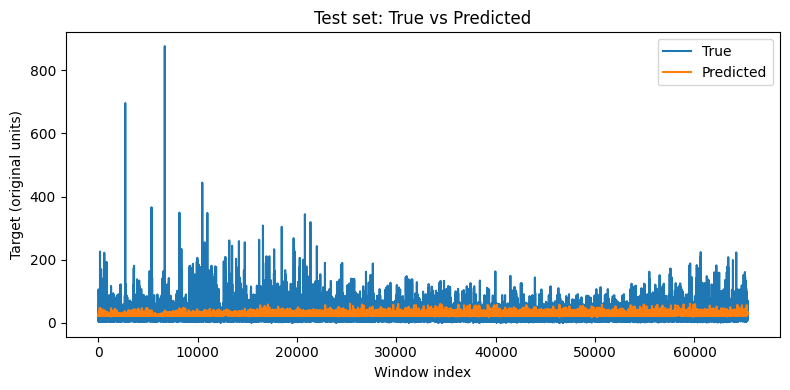

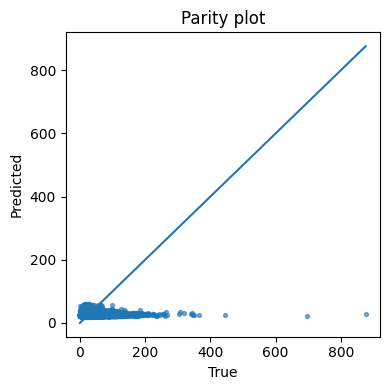

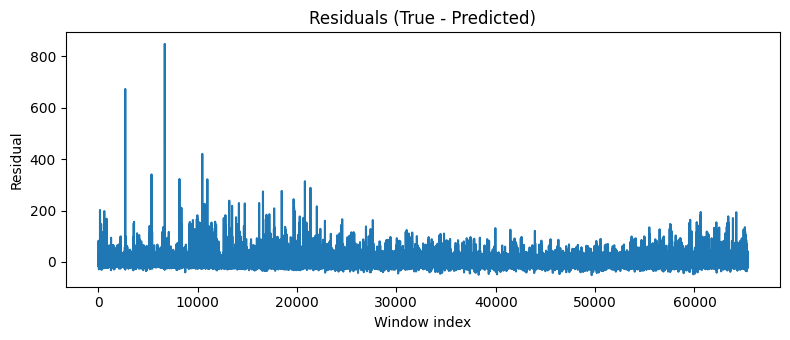

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Test series: true vs predicted
plt.figure(figsize=(8, 4))
plt.plot(ytrue_te.flatten(), label="True")
plt.plot(yhat_te.flatten(), label="Predicted")
plt.title("Test set: True vs Predicted")
plt.xlabel("Window index"); plt.ylabel("Target (original units)")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Parity plot
plt.figure(figsize=(4, 4))
plt.scatter(ytrue_te, yhat_te, s=8, alpha=0.6)
mn = float(min(ytrue_te.min(), yhat_te.min()))
mx = float(max(ytrue_te.max(), yhat_te.max()))
plt.plot([mn, mx], [mn, mx])
plt.title("Parity plot")
plt.xlabel("True"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

# 3) Residuals over test windows
res = (ytrue_te - yhat_te).flatten()
plt.figure(figsize=(8, 3.5))
plt.plot(res)
plt.title("Residuals (True - Predicted)")
plt.xlabel("Window index"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

In [14]:

# Save artifacts
ART_DIR = "/mnt/data/airquality_rnn_artifacts_v2"
os.makedirs(ART_DIR, exist_ok=True)
model_path = os.path.join(ART_DIR, "rnn_model_v2.keras")
xscaler_path = os.path.join(ART_DIR, "x_scaler.pkl")
yscaler_path = os.path.join(ART_DIR, "y_scaler.pkl")
meta_path = os.path.join(ART_DIR, "meta.json")

model.save(model_path)
with open(xscaler_path, "wb") as f:
    pickle.dump(x_scaler, f)
with open(yscaler_path, "wb") as f:
    pickle.dump(y_scaler, f)
with open(meta_path, "w") as f:
    json.dump({
        "TARGET": TARGET,
        "LOOKBACK_USED": int(LOOKBACK_USED),
        "HORIZON": int(HORIZON),
        "n_features": int(n_features),
        "target_idx": int(cols.index(TARGET))
    }, f, indent=2)

print("Saved artifacts to:", ART_DIR)


Saved artifacts to: /mnt/data/airquality_rnn_artifacts_v2
